In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
!pip install vaderSentiment

In [432]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import nltk
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize,sent_tokenize
from gensim import corpora
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt


In [450]:
#df_train = pd.read_csv("data/reddit_200k_train.csv",encoding="iso-8859-1")[["body","REMOVED"]]
df_train = pd.read_csv("labeled_data.csv")[["tweet","class"]]

df_train.loc[df_train['class'] == 2, 'class'] = 1

In [451]:
df_test = pd.read_csv("comments.csv")[["comments"]]
# df_test = pd.read_csv("data/reddit_200k_test.csv",encoding="iso-8859-1")[["body","REMOVED"]]

In [452]:
df_train.head()


,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,1
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [453]:
df_test.head()

,comments
0,Let me quess these are like the creators that ...
1,this is an example. here's a really random num...
2,YouTube: lets make a list of the most popular ...
3,Now I get it this is why I have been getting s...
4,ThIs iS ThWaSh


In [454]:
X_train = df_train[df_train['class']==0]["tweet"]
X__train = df_train[df_train['class']==1]["tweet"][:1000]
X_train = X_train.append(X__train)
y_train = df_train[df_train['class']==0]["class"]
y_train = y_train.append(df_train[df_train['class']==1]["class"][:1000])

len(X_train)

2430

In [455]:
len(y_train)

2430

In [457]:
#X_test = df_test["comments"]

##Baseline model

In [458]:
pipe  =  make_pipeline(CountVectorizer(),LogisticRegression(solver="sag"))
print("Cross val score on baseline model")
pipe.fit(X_train,y_train)
print(np.mean(cross_val_score(pipe,X_train,y_train,cv=5,scoring="roc_auc")))

Cross val score on baseline model


/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8547884615384616


/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


##Re-implementing the paper

1. Lowercase
2. Stem
3. bigram, unigram, trigram features, weighted by its tfidf
4. POS tag
5. FK Grade level
6. FK reading ease score
7. sentiment scores

8. binary indicators for: hashtags, mentions, retweets, urls
9. count indicatiors for :hashtags, mentions, retweets, urls
10. number of characters
11. numbers of words
12. number of syllables



In [459]:
nltk.download("stopwords")
from nltk.stem.porter import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankitpeshin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [460]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt","RT"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    
    #Lowercase string
    text_string=text_string.lower()
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    
    #Stem it
    tweet = " ".join(re.split("[^a-zA-Z]*", parsed_text)).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens
  
  
def pos_tag_seq(tokens):
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    return tag_str
  
  

In [306]:
def join_sent(l):
  return " ".join(l)

In [461]:
df_train=pd.DataFrame(X_train)

In [462]:
df_train.columns=["tweet"]

In [463]:
df_train.head()

,tweet
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [464]:
s_train=df_train['tweet'].apply(preprocess)

/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [465]:
s_tr=s_train.apply(join_sent)

In [466]:
nltk.download('averaged_perceptron_tagger')
t_tr=s_train.apply(pos_tag_seq)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ankitpeshin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [467]:
vectorizer = TfidfVectorizer(
    preprocessor=None,
    lowercase=False,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    stop_words=stopwords,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [468]:
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [469]:
tfidf_tr = vectorizer.fit_transform(s_tr).toarray()

vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

In [470]:
pos_tr = pos_vectorizer.fit_transform(t_tr).toarray()

pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [471]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
sentiment_analyzer = VS()


In [472]:
def get_sentiment(text):
  sentiment = sentiment_analyzer.polarity_scores(text)
  return sentiment

#   return sentiment["neg"], sentiment["pos"], sentiment["neu"]

In [473]:
df_train["sent"]=df_train["tweet"].apply(get_sentiment) 

In [474]:
df_train.head()

,tweet,sent
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...","{'neg': 0.187, 'neu': 0.813, 'pos': 0.0, 'comp..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...","{'neg': 0.254, 'neu': 0.746, 'pos': 0.0, 'comp..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http...","{'neg': 0.232, 'neu': 0.488, 'pos': 0.28, 'com..."


In [475]:
foo_tr = lambda x: pd.Series([x["pos"],x["neg"],x["neu"]])
rev_tr = df_train['sent'].apply(foo_tr)


In [476]:
rev_tr.columns=["pos","neg","neu"]

In [477]:
rev_tr.head()

,pos,neg,neu
85,0.00,0.000,1.000
89,0.00,0.187,0.813
110,0.00,0.000,1.000
184,0.00,0.254,0.746
202,0.28,0.232,0.488


##Binary count for URL https mentions etc 

In [478]:
def return_cont(parsed_text):
  return(parsed_text.count('urlher'),parsed_text.count('mentionher'),parsed_text.count('hashtagher'))

In [479]:
df_train["counts"]=s_tr.apply(return_cont) 

In [480]:
df_train["counts"].head()

85     (0, 3, 0)
89     (0, 2, 0)
110    (1, 2, 1)
184    (1, 1, 0)
202    (1, 1, 0)
Name: counts, dtype: object

In [481]:
foo = lambda x: pd.Series([x[0],x[1],x[2]])
mention_counts_tr = df_train['counts'].apply(foo)


In [482]:
mention_counts_tr.head()

,0,1,2
85,0,3,0
89,0,2,0
110,1,2,1
184,1,1,0
202,1,1,0


##FKRA and Flesch and number of syllables etc

In [483]:
!pip install textstat
from textstat.textstat import *

In [484]:
def get_other_features(text):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    words = re.sub(mention_regex, '', parsed_text)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_terms, num_words,
                num_unique_terms]
    return features
    
  

In [485]:
other_feats_tr=df_train["tweet"].apply(get_other_features)

In [486]:
other_feats_tr.head()

85         [9.2, 34.62, 6, 1.9997, 18, 5, 3, 3]
89        [6.8, 67.76, 18, 1.5, 59, 13, 12, 10]
110    [9.1, 49.55, 19, 1.7272, 76, 13, 11, 11]
184    [5.2, 84.46, 19, 1.2666, 78, 15, 15, 15]
202        [2.3, 94.3, 11, 1.2222, 38, 9, 9, 9]
Name: tweet, dtype: object

In [487]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars","num_terms", "num_words", "num_unique_words"]

In [488]:
foo = lambda x: pd.Series(elem for elem in x)
of_counts_tr = other_feats_tr.apply(foo)

In [489]:
of_counts_tr.head()

,0,1,2,3,4,5,6,7
85,9.2,34.62,6.0,1.9997,18.0,5.0,3.0,3.0
89,6.8,67.76,18.0,1.5000,59.0,13.0,12.0,10.0
110,9.1,49.55,19.0,1.7272,76.0,13.0,11.0,11.0
184,5.2,84.46,19.0,1.2666,78.0,15.0,15.0,15.0
202,2.3,94.30,11.0,1.2222,38.0,9.0,9.0,9.0


In [491]:
of_counts_tr.columns=other_features_names

In [361]:
of_counts_tr.head()

,FKRA,FRE,num_syllables,avg_syl_per_word,num_chars,num_terms,num_words,num_unique_words
16448,8.3,76.82,29.0,1.2609,119.0,23.0,23.0,20.0
23858,0.1,112.09,10.0,1.0000,38.0,10.0,10.0,10.0
316,2.5,95.17,12.0,1.2000,50.0,10.0,10.0,9.0
999,2.3,92.97,10.0,1.2500,85.0,9.0,8.0,8.0
7137,8.0,71.78,26.0,1.3684,96.0,20.0,19.0,18.0


In [492]:
df_train.drop([ "sent","counts"], axis=1)

,tweet
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http..."
204,"""@NotoriousBM95: @_WhitePonyJr_ Ariza is a sna..."
219,"""@RTNBA: Drakes new shoes that will be release..."
260,"""@TheoMaxximus: #GerrysHalloweenParty http://t..."
312,"""@ashlingwilde: @ItsNotAdam is bored supposed ..."
315,"""@bigbootybishopp: @white_thunduh lassen cc , ..."


In [493]:
for elem in [pd.DataFrame(tfidf_tr),pd.DataFrame(pos_tr),rev_tr,mention_counts_tr, of_counts_tr]:
  print(len(elem))


2430
2430
2430
2430
2430


In [494]:
# x_train=np.column_stack([tfidf,pos,rev,mention_counts, other_feats])
x_train=np.concatenate([pd.DataFrame(tfidf_tr),pd.DataFrame(pos_tr),rev_tr,mention_counts_tr, of_counts_tr],axis=1 )


x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)


In [495]:
print(len(x_train))

1944


In [499]:
print(len(y_train))

1944


In [500]:
param_grid = {"logisticregression__C": [100,10,1,0.1,0.01],}
grid = GridSearchCV(make_pipeline(LogisticRegression(solver="sag"),memory="cache_folder"),param_grid=param_grid, cv=5, scoring="roc_auc")


In [501]:
grid.fit(x_train, y_train)

/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-pac

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory='cache_folder',
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [502]:
grid.best_score_

0.8834181593181153

In [503]:
grid.cv_results_

/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, *

{'mean_fit_time': array([2.16524444, 2.06829972, 1.97672482, 1.9708775 , 2.00960221]),
 'std_fit_time': array([0.02475087, 0.04959867, 0.01641614, 0.02279882, 0.03616357]),
 'mean_score_time': array([0.00231876, 0.00185647, 0.00178199, 0.00178285, 0.00183835]),
 'std_score_time': array([5.37526086e-04, 1.06457951e-04, 2.37134336e-05, 1.70280946e-05,
        1.34951706e-04]),
 'param_logisticregression__C': masked_array(data=[100, 10, 1, 0.1, 0.01],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'logisticregression__C': 100},
  {'logisticregression__C': 10},
  {'logisticregression__C': 1},
  {'logisticregression__C': 0.1},
  {'logisticregression__C': 0.01}],
 'split0_test_score': array([0.86661198, 0.86691277, 0.86683074, 0.86669401, 0.86445174]),
 'split1_test_score': array([0.891277  , 0.89042931, 0.8910309 , 0.89094887, 0.88802297]),
 'split2_test_score': array([0.90147662, 0.90196883, 0.90185945, 0.90172272, 0

In [504]:
grid.best_params_

{'logisticregression__C': 100}

## Evaluating Model Performance

In [539]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC,SVC


### In-Sample Predictive Performance

In [620]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=10))
X_ = select.fit_transform(x_train,y_train)
model = SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True).fit(X_, y_train)


/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [621]:
y_preds = model.predict(X_)

In [622]:
report = classification_report( y_preds, y_train )

In [623]:
print(report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1078
           1       0.95      0.88      0.91       866

   micro avg       0.93      0.93      0.93      1944
   macro avg       0.93      0.92      0.92      1944
weighted avg       0.93      0.93      0.93      1944



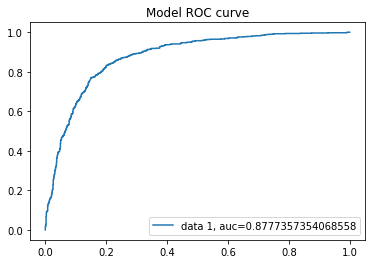

In [624]:
clf = Pipeline(steps=[('classifier', SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True))])
clf.fit(x_train,y_train)

proba = cross_val_predict(clf, x_train,y_train, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_train,  proba[::,1])
auc = metrics.roc_auc_score(y_train, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Model ROC curve')
plt.show()

/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


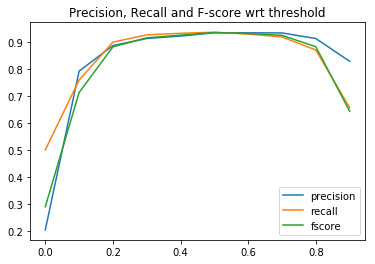

In [625]:
from sklearn.metrics import precision_recall_fscore_support as score

thresh_range = list(np.arange(0,1,0.1))
p_list = list()
r_list = list()
f_list = list()
for threshold in thresh_range:
    y_preds = np.where(model.predict_proba(X_)[:,1] > threshold, 1, 0)
    precision,recall,fscore,support=score(y_train,y_preds,average='macro')
    p_list.append(precision)
    r_list.append(recall)
    f_list.append(fscore)
plt.plot(thresh_range,p_list,label='precision')
plt.plot(thresh_range,r_list,label='recall')
plt.plot(thresh_range,f_list,label='fscore')
plt.title('Precision, Recall and F-score wrt threshold')
plt.legend()


### Out-of-sample Predictive Performance

In [626]:

model = SVC(kernel='linear',class_weight='balanced',C=0.01,probability=True).fit(x_train, y_train)

y_preds = model.predict(x_test)
report = classification_report( y_test, y_preds )

In [627]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       280
           1       0.76      0.83      0.79       206

   micro avg       0.82      0.82      0.82       486
   macro avg       0.81      0.82      0.81       486
weighted avg       0.82      0.82      0.82       486



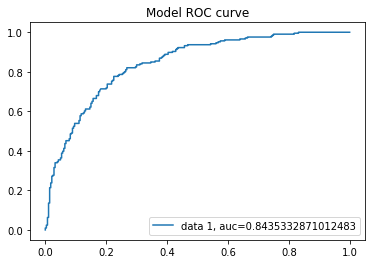

In [609]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

clf = Pipeline(steps=[('classifier', SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True))])
clf.fit(x_train,y_train)

proba = cross_val_predict(clf, x_test,y_test, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  proba[::,1])
auc = metrics.roc_auc_score(y_test, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Model ROC curve')
plt.show()

The AUC falls from 0.878 for in-sample to 0.843 for out-of-sample.

/Users/ankitpeshin/anaconda2/envs/aml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


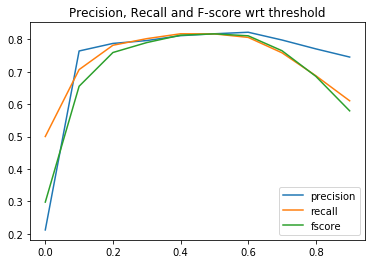

In [628]:
from sklearn.metrics import precision_recall_fscore_support as score

thresh_range = list(np.arange(0,1,0.1))
p_list = list()
r_list = list()
f_list = list()
for threshold in thresh_range:
    y_preds = np.where(model.predict_proba(x_test)[:,1] > threshold, 1, 0)
    precision,recall,fscore,support=score(y_test,y_preds,average='macro')
    p_list.append(precision)
    r_list.append(recall)
    f_list.append(fscore)
plt.plot(thresh_range,p_list,label='precision')
plt.plot(thresh_range,r_list,label='recall')
plt.plot(thresh_range,f_list,label='fscore')
plt.title('Precision, Recall and F-score wrt threshold')
plt.legend()


### Effects of Statistical Significance on Predictive Power

In [ ]:
import statsmodels.formula.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(x_train, y_train, SL, range(x_train.shape[1]))


In [639]:
x_train[.shape]

(1944, 2033)

                 A            B
count  2430.000000  2430.000000
mean      0.411523     0.411934
std       0.492211     0.492285
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       1.000000     1.000000
max       1.000000     1.000000


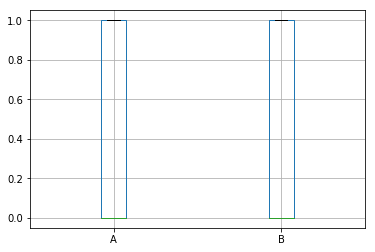

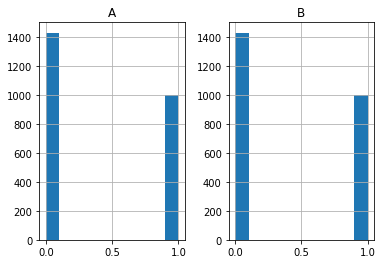

In [152]:
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd
# load results file
results = pd.DataFrame()
results['A'] = y
results['B'] = y_preds
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()
# histogram
results.hist()
pyplot.show()

In [155]:
from scipy.stats import ttest_ind
value, pvalue = ttest_ind(y, y_preds, equal_var=True)
print(value, pvalue)
if pvalue > 0.05:
	print('Samples are likely drawn from the same distributions (fail to reject H0)')
else:
	print('Samples are likely drawn from different distributions (reject H0)')

-0.029140578637050166 0.9767536694548906
Samples are likely drawn from the same distributions (fail to reject H0)
